# Initialization

In [3]:
import nltk
from nltk.corpus import words
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000  # 100k elements in the stream
NUM_UNIQUE = 10000  # 10k unique elements
NUM_RUNS = 25
NUM_SKETCHES = 20

# Set the seed for reproducibility
np.random.seed(SEED)

nltk.download('words')

word_list = words.words()

# Sample 10k distinct elements
unique_words = set(word_list)
distinct_elements = list(unique_words)[:NUM_UNIQUE]

# Generate the stream
stream = np.random.choice(distinct_elements, size=NUM_ELEMENTS)

# Shuffle the stream
np.random.shuffle(stream)

stream = np.array(stream)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

# Generate sketches
sketch_sizes = np.logspace(1, np.log10(NUM_ELEMENTS), num=NUM_SKETCHES, base=10, dtype=int)
print(f"Sketch sizes: {sketch_sizes}")


Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: ['nonsensitized' 'superhearty' 'meteoristic' 'pummice' 'phototactism'
 'archer' 'Mysidae' 'feeler' 'Jebusite' 'submarinist']
Sketch sizes: [    10     16     26     42     69    112    183    297    483    784
   1274   2069   3359   5455   8858  14384  23357  37926  61584 100000]


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\galno\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [26]:
def hash_fn(element, seed=SEED) -> float:
    """
    Hash function that maps an element to a random number between 0 and 1.
    :param element: The element to hash
    :param seed: The seed for the hash function
    """
    return (hash(f"{element}{seed}") % 2**32) / 2**32

def vectorized_hash_fn(stream: np.ndarray, seed=SEED) -> np.ndarray:
    """
    Vectorized hash function that maps a stream of elements to a random number between 0 and 1.
    """
    return (np.vectorize(hash_fn)(stream, seed))

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [27]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    hashed_stream = vectorized_hash_fn(stream)
    return 1 / np.min(hashed_stream)

### Flajolet Martin - Beta Version

In [30]:
from typing import Optional
from concurrent.futures import ThreadPoolExecutor

def flajolet_martin_beta(stream: np.ndarray, s: int, seeds: Optional[np.ndarray] = None) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seeds: numpy array of seeds for the hash functions
    :return: estimated number of distinct elements
    """
    seeds = range(s) if seeds is None else seeds
    assert len(seeds) == s, "Number of seeds must match the number of FM estimators"

    Z = [np.min(vectorized_hash_fn(stream, seed)) for seed in seeds]
    return 1 / np.mean(Z) - 1

print(f"Estimated number of distinct elements in the stream (beta): {flajolet_martin_beta(stream, 100)}")


Estimated number of distinct elements in the stream (beta): 11573.340265665875


### Flajolet Martin - Final Version

In [6]:
from concurrent.futures import ThreadPoolExecutor

def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """
    seeds = np.arange(1, t * s + 1)
    
    with ThreadPoolExecutor() as executor:
        estimates = list(executor.map(
            lambda idx: flajolet_martin_beta(stream, s, seeds[idx * s: (idx + 1) * s]),
            range(t)
        ))
    
    return np.median(estimates)

Run 25 times for each sketch size

In [ ]:
delta = 0.05  # 95% confidence interval
delta_beta = 1/3

def process_sketch(sketch_size: int) -> tuple:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: tuple of FM, FM-beta, and FM-final estimates
    """
    epsilon = np.sqrt(np.log(1 / delta) / sketch_size)
    
    s = int(np.ceil(1 / (epsilon**2 * delta_beta)))
    t = int(np.ceil(np.log(1 / delta) / epsilon**2))
    
    print(f"Sketch size: {sketch_size}, epsilon: {epsilon:.2f}, s: {s}, t: {t}")
    
    fm_results = []
    fm_beta_results = []
    fm_final_results = []
    
    for _ in range(NUM_RUNS):
        # Generate sketch
        indices = np.random.choice(len(stream), size=sketch_size, replace=False)
        sketch = stream[indices]
        
        # Calculate FM, FM-beta, and FM-final estimates
        fm_estimate = flajolet_martin(sketch)
        fm_beta_estimate = flajolet_martin_beta(sketch, s)
        fm_final_estimate = flajolet_martin_final(sketch, t, s)
        
        fm_results.append(fm_estimate)
        fm_beta_results.append(fm_beta_estimate)
        fm_final_results.append(fm_final_estimate)
    
    print(f"Sketch size: {sketch_size}, FM estimate: {np.mean(fm_results):.2f}, FM-beta estimate: {np.mean(fm_beta_results):.2f}, FM-final estimate: {np.mean(fm_final_results):.2f}")
    return (fm_results, fm_beta_results, fm_final_results)

fm_results, fm_beta_results, fm_final_results = {}, {}, {}

true_unique = len(np.unique(stream))
print(f"True number of unique elements: {true_unique}")

with ThreadPoolExecutor() as executor:
    futures = {sketch_size: executor.submit(process_sketch, sketch_size) for sketch_size in sketch_sizes}
    
    for sketch_size, future in futures.items():
        sz_fm_results, sz_fm_beta_results, sz_fm_final_results = future.result()
        
        fm_results[sketch_size] = sz_fm_results
        fm_beta_results[sketch_size] = sz_fm_beta_results
        fm_final_results[sketch_size] = sz_fm_final_results


True number of unique elements: 10000
Sketch size: 10, epsilon: 0.55, s: 11, t: 10
Sketch size: 16, epsilon: 0.43, s: 17, t: 16
Sketch size: 26, epsilon: 0.34, s: 27, t: 27
Sketch size: 42, epsilon: 0.27, s: 43, t: 43
Sketch size: 69, epsilon: 0.21, s: 70, t: 70
Sketch size: 112, epsilon: 0.16, s: 113, t: 112
Sketch size: 183, epsilon: 0.13, s: 184, t: 184
Sketch size: 297, epsilon: 0.10, s: 298, t: 297
Sketch size: 483, epsilon: 0.08, s: 484, t: 483
Sketch size: 784, epsilon: 0.06, s: 786, t: 785


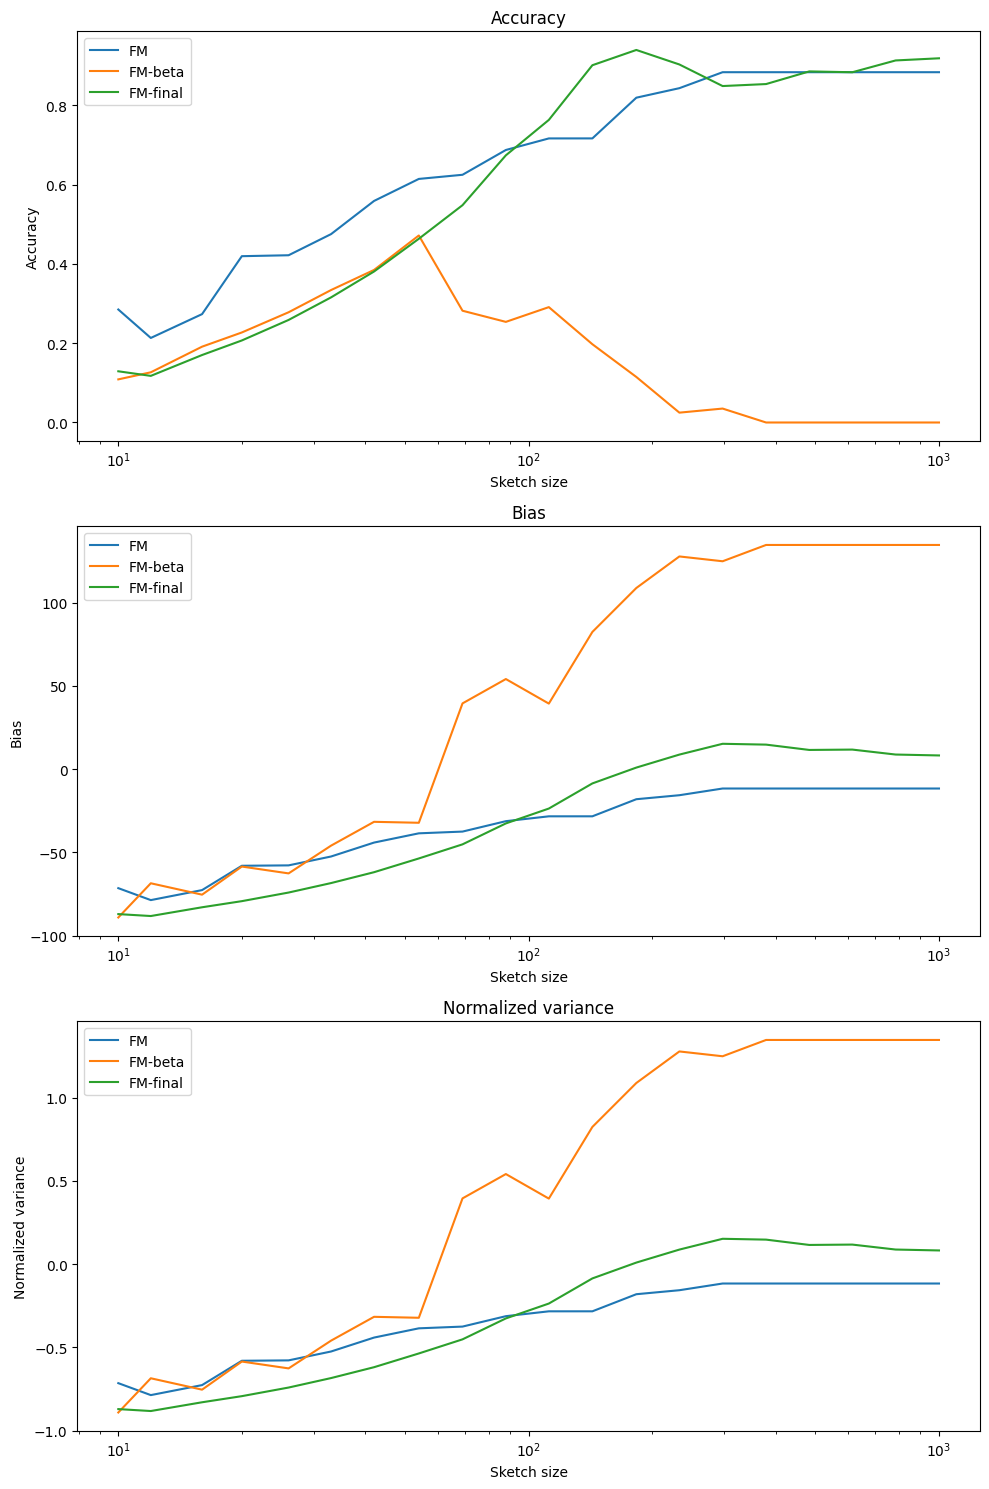

In [7]:
import matplotlib.pyplot as plt

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": np.mean([max(0, 1 - abs(est - true_unique) / true_unique) for est in size_estimates]),
            "bias": np.mean([est - true_unique for est in size_estimates]),
            "normalized_variance": np.mean([((est - true_unique) / true_unique) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM")
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta")
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final")
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM")
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta")
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final")
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM")
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta")
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final")
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()